# Arbol de Decisión

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from preprocessing import *
np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [2]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [3]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [4]:
volver = ['volveria']
columnas = columnillas + volver

In [5]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [6]:
df.shape

(801, 15)

# Entrenamiento

X.shape:  (801, 14)
y.shape:  (801,) 



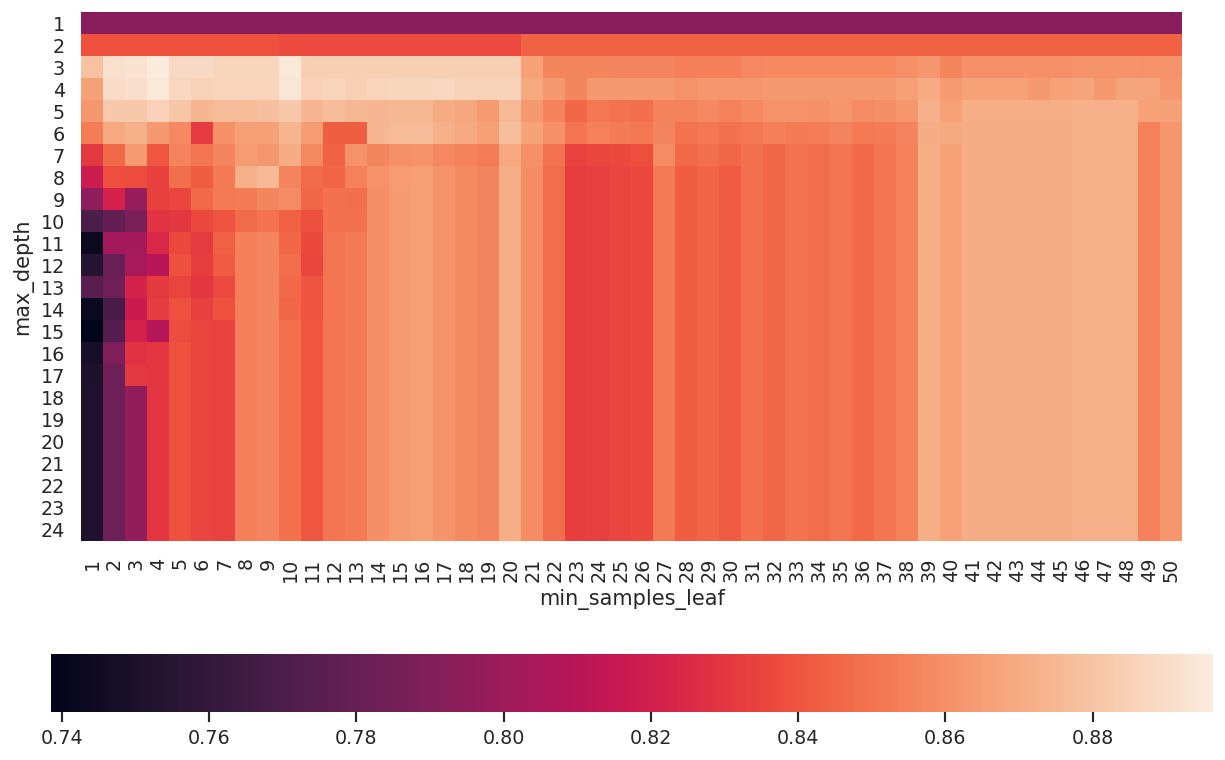

In [7]:
def split_dataset_test_and_train (df, df_columns):
    X = df.loc[:, df_columns]
    y = df.loc[:, 'volveria']
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape, "\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)
    return X_train, X_test, y_train, y_test


def params_search_for_decision_tree (X_train, X_test, y_train, y_test):
    max_depths = np.arange(1, 25)
    min_samples_leafs = np.arange(1, 51)
    data_points = []
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leafs:
            clf = DecisionTreeClassifier(
                max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
            )
            clf.fit(X_train, y_train)
            data_points.append((max_depth, min_samples_leaf, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]),))

    data_points = pd.DataFrame(
        data_points, columns=["max_depth", "min_samples_leaf", "score"]
    )
    return data_points


def find_params_for_decision_tree (X_train, X_test, y_train, y_test):
    data_points = params_search_for_decision_tree(X_train, X_test, y_train, y_test)
    plt.figure(dpi=125, figsize=(12, 8))
    g = sns.heatmap(data_points.pivot_table(index="max_depth", columns="min_samples_leaf", values="score"),
                    square=True,cbar_kws=dict(use_gridspec=False, location="bottom"),)

X_train, X_test, y_train, y_test = split_dataset_test_and_train(df, columnillas)    
find_params_for_decision_tree(X_train, X_test, y_train, y_test)

# Baseline

Entrenamos el modelo considerando parámetros que nos parecen razonables, en base al plot

In [8]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=117)
clf.fit(X_train, y_train)
X = df.loc[:, columnillas]
y = df.loc[:, 'volveria']    

In [9]:
def apply_stratified_k_fold_to_clf (X, y, max_depth, min_samples_leaf):
    kf = StratifiedKFold(n_splits=5)
    test_rocs = []
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
        arbol = DecisionTreeClassifier(
            max_depth = max_depth,
            min_samples_leaf = min_samples_leaf,
            random_state = 117)
        
        arbol.fit(X.iloc[train_index], y.iloc[train_index])
        test_roc = roc_auc_score(y.iloc[test_index], arbol.predict(X.iloc[test_index]))
        print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
        test_rocs.append(test_roc)
    print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")
    return arbol

arbol = apply_stratified_k_fold_to_clf(X,y,3,10)

Fold 0: AUC ROC score is 0.7357
Fold 1: AUC ROC score is 0.7994
Fold 2: AUC ROC score is 0.8637
Fold 3: AUC ROC score is 0.7856
Fold 4: AUC ROC score is 0.7796
Mean test AUC ROC is: 0.7928


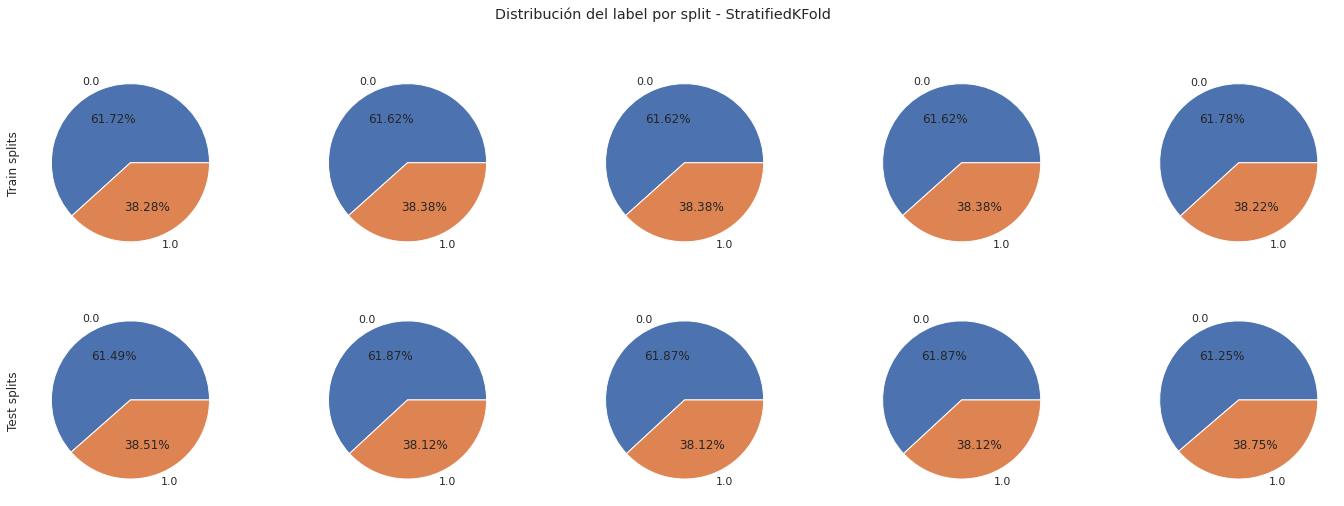

In [10]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 8), sharey=True)

kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    pd.Series(y[train_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[0][fold_idx]
    )
    pd.Series(y[test_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[1][fold_idx]
    )

axes[0][0].set_ylabel("Train splits")
axes[1][0].set_ylabel("Test splits")
plt.suptitle("Distribución del label por split - StratifiedKFold")

plt.show()

# Métricas

In [11]:
def get_scores(model, X, y):
    scores = {}
    scores['AUC ROC'] = roc_auc_score(y, model.predict_proba(X)[:,1])
    scores['Accuracy'] = accuracy_score(y, model.predict(X))
    scores['Precision'] = precision_score(y, model.predict(X))
    scores['Recall'] = recall_score(y, model.predict(X), pos_label=0)
    scores['F1-Score'] = f1_score(y, model.predict(X))

    for score in scores:
        print(f"{score} : {scores[score]:.4f}")
    return scores

scores = get_scores(arbol, X_test, y_test)

AUC ROC : 0.8906
Accuracy : 0.8557
Precision : 0.8261
Recall : 0.9055
F1-Score : 0.7972


## Matriz de confusión

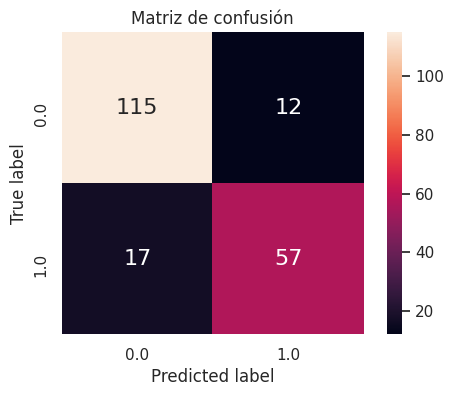

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, arbol.predict(X_test))

## Viendo el modelo

Dado que obtuvimos un 86% de accuracy y un 81% con Stratified K fold, no está demás imprimir el arbol para ver cómo decide

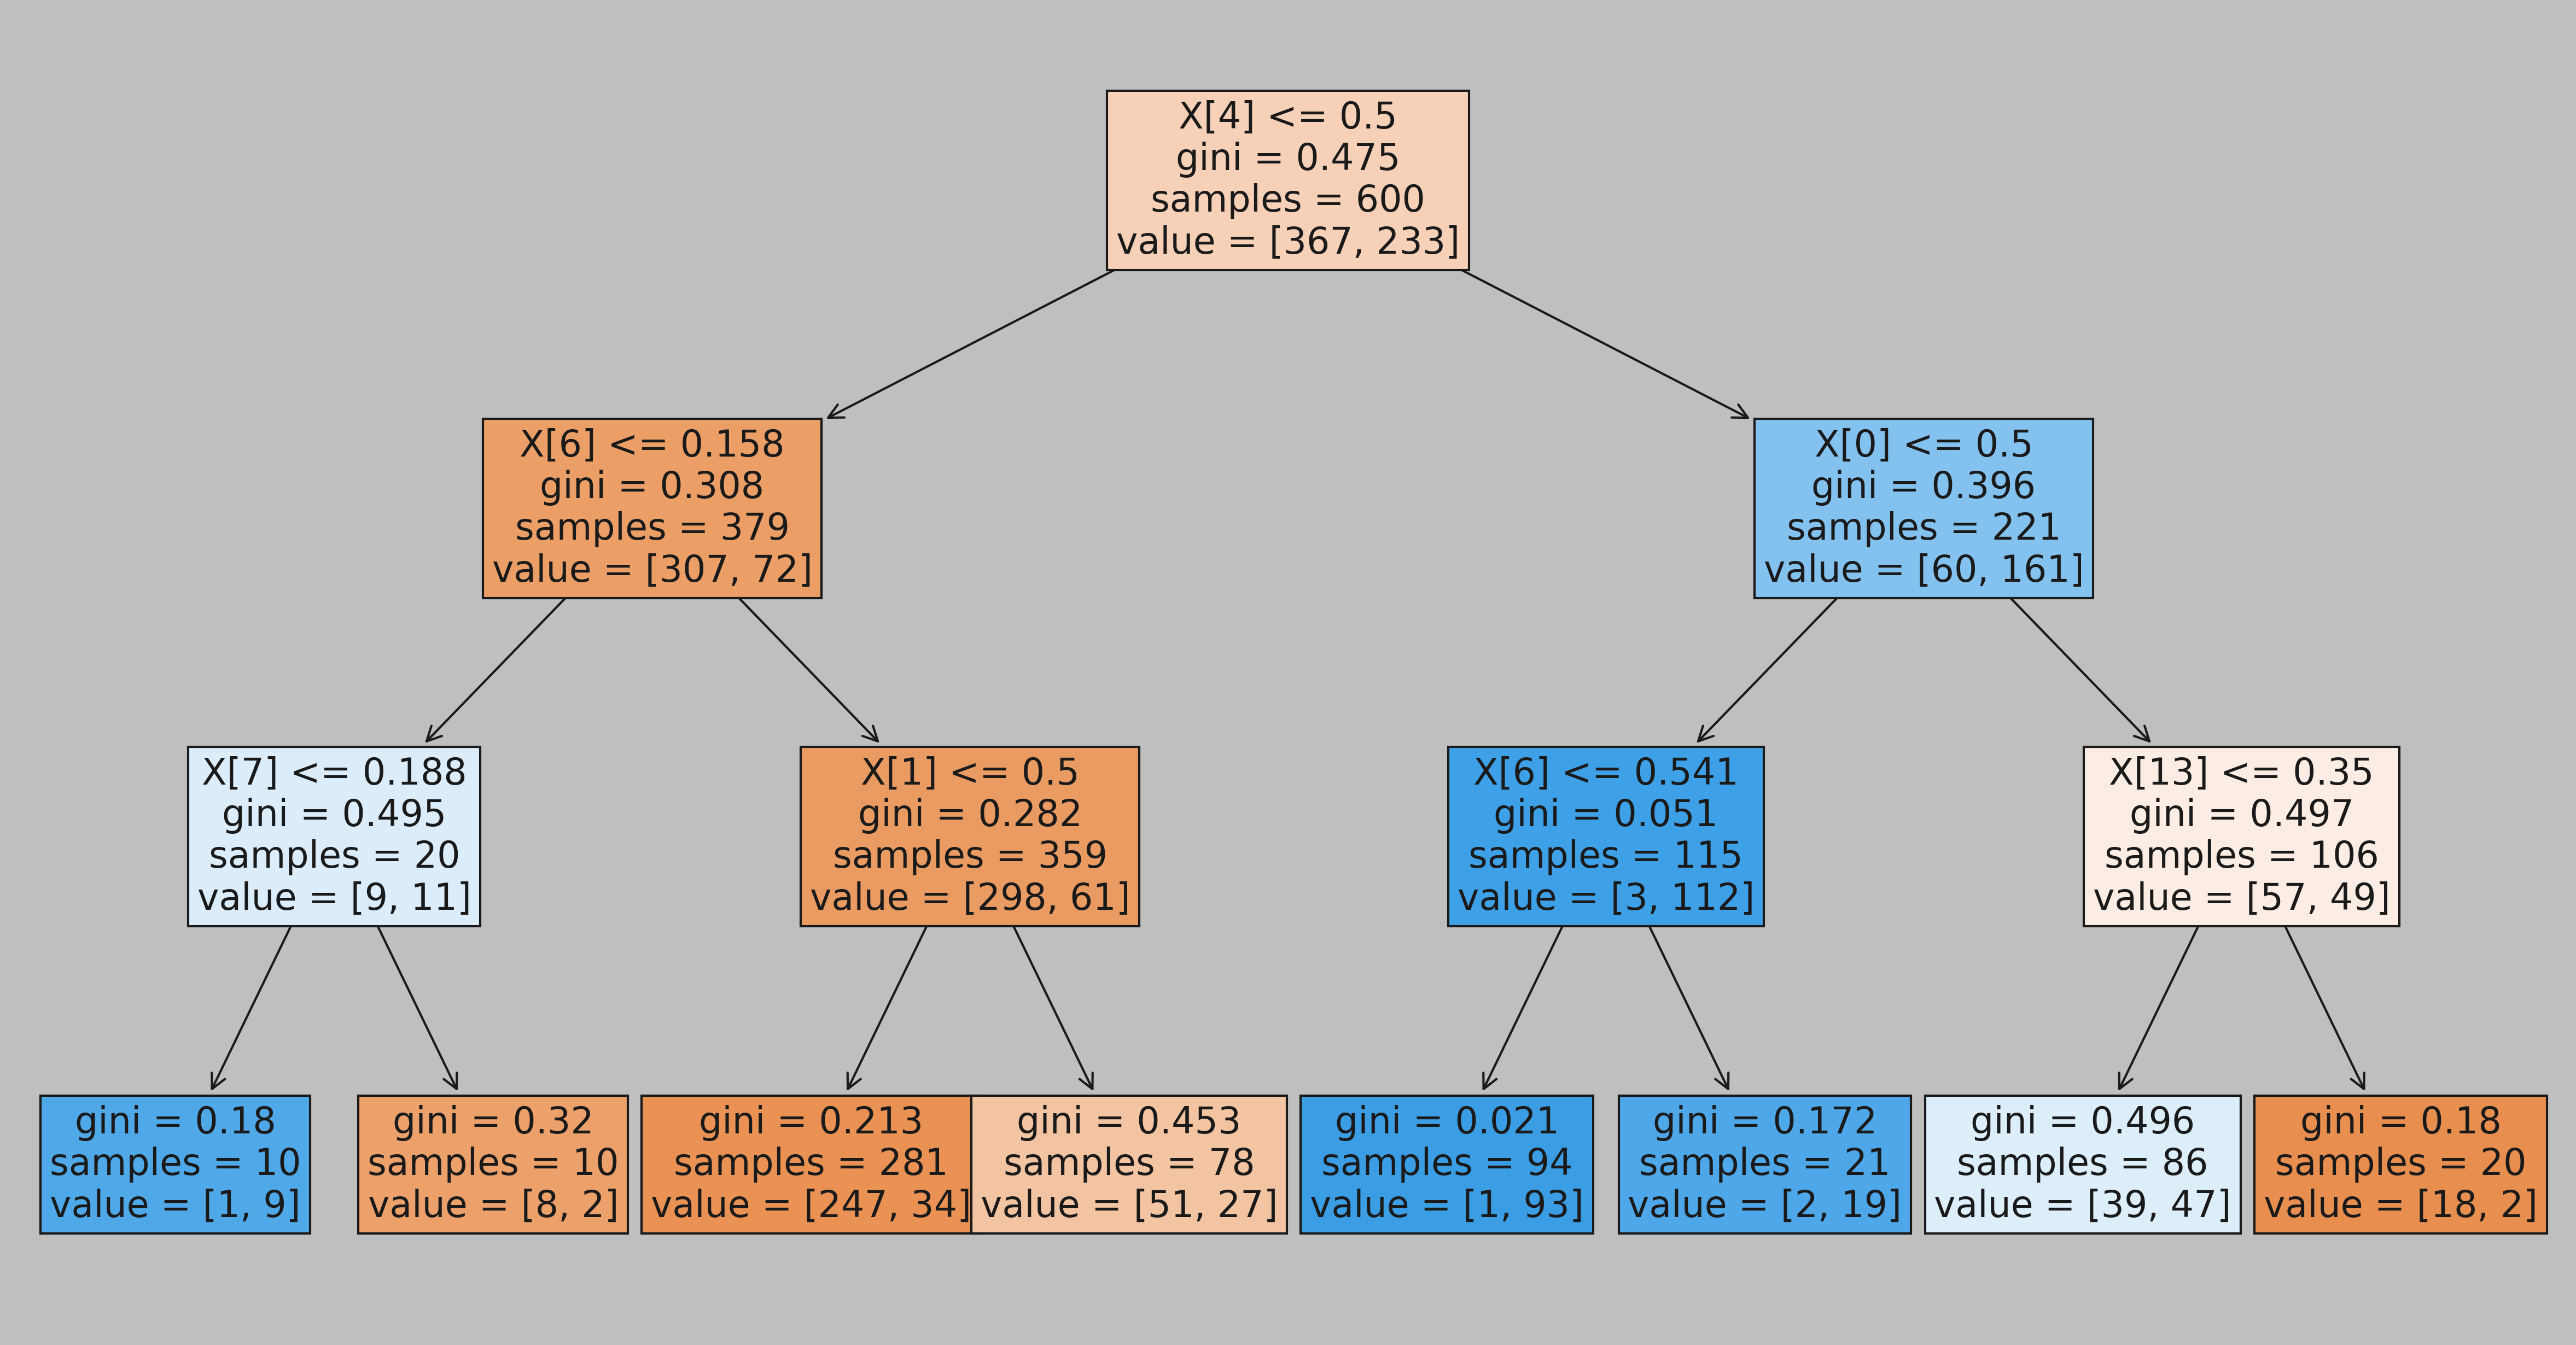

In [13]:
with plt.style.context("classic"):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=300)
    plot_tree(clf, filled=True, fontsize=16)

# Test Holdout

Por último, para validar contra datos nunca vistos, usamos un conjunto de holdout.

En este caso, y para todos los modelos de este TP, es un nuevo archivo para el que no poseemos los valores a predecir

In [14]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [15]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [16]:
def evaluate_holdout(holdout_df, model):
    y_pred = model.predict(holdout_df)
    y_pred = y_pred.astype(int)
    print("y_pred.shape: ", y_pred.shape)
    print("holdout_df.shape: ", holdout_df.shape, "\n")
    serie_predicha = pd.Series(y_pred, name='volveria')
    serie_predicha = serie_predicha.to_frame()
    df_predicho = holdout.join(serie_predicha, how='inner')
    cols = ['id_usuario', 'volveria']
    df_resultado = df_predicho[cols]
    return df_resultado

df_resultado = evaluate_holdout(df_h, arbol)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [17]:
df_resultado.to_csv('prediccion/arbol_resultado_final.csv')

## Preprocesado 2

In [18]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = eliminar_feature(df, 'edad')
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [19]:
seguidores = ['cant_acompañantes', 'edad']
columnas_nuevas = set(columnas) - set(seguidores)
columnas_nuevas

{'amigos',
 'genero_mujer',
 'genero_nan',
 'id_usuario',
 'nombre_sede_fiumark_palermo',
 'nombre_sede_fiumark_quilmes',
 'nombre_sede_nan',
 'parientes',
 'precio_ticket',
 'tipo_de_sala_4d',
 'tipo_de_sala_nan',
 'tipo_de_sala_normal',
 'volveria'}

In [20]:
df_2 = preprocesado_2(dataset, columnas_nuevas)
df_2.head()

,tipo_de_sala_nan,amigos,nombre_sede_fiumark_quilmes,tipo_de_sala_normal,precio_ticket,nombre_sede_nan,nombre_sede_fiumark_palermo,genero_mujer,tipo_de_sala_4d,parientes,genero_nan,id_usuario,volveria
0,0,0,1,0,1,0,0,0,1,0,0,117,0
1,0,1,1,0,2,0,0,1,1,1,0,658,0
2,0,0,0,1,3,0,0,0,0,0,0,794,0
3,0,0,0,0,1,0,1,0,1,0,0,455,0
4,0,1,0,0,2,0,1,1,1,1,0,173,1


In [21]:
df_2.shape

(801, 13)

In [22]:
columnas_2 = ['genero_mujer', 'genero_nan', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'tipo_de_sala_4d',
              'nombre_sede_nan', 'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes',
              'amigos', 'precio_ticket', 'precio_ticket', 'id_usuario']

X.shape:  (801, 12)
y.shape:  (801,) 



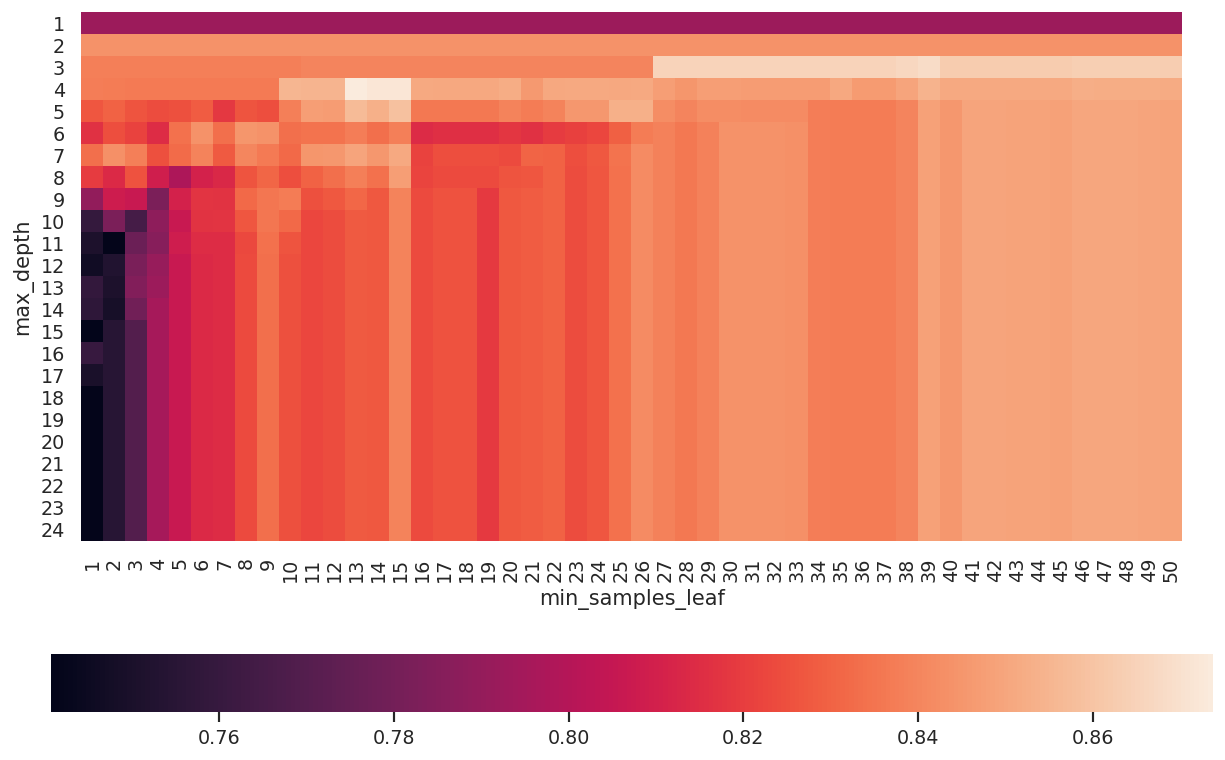

In [23]:
X_train_2, X_test_2, y_train_2, y_test_2 = split_dataset_test_and_train(df_2, columnas_2)    
find_params_for_decision_tree(X_train_2, X_test_2, y_train_2, y_test_2)


In [24]:
clf_2 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=13, random_state=117)
clf_2.fit(X_train_2, y_train_2)
X_2 = df_2.loc[:, columnas_2]
y_2 = df_2.loc[:, 'volveria']

In [25]:
arbol_2 = apply_stratified_k_fold_to_clf(X_2,y_2,4,13)

Fold 0: AUC ROC score is 0.6995
Fold 1: AUC ROC score is 0.7591
Fold 2: AUC ROC score is 0.7995
Fold 3: AUC ROC score is 0.7723
Fold 4: AUC ROC score is 0.7855
Mean test AUC ROC is: 0.7632


## Métricas

In [26]:
scores_2 = get_scores(arbol_2, X_test_2, y_test_2)

AUC ROC : 0.8748
Accuracy : 0.8408
Precision : 0.8000
Recall : 0.8898
F1-Score : 0.7778


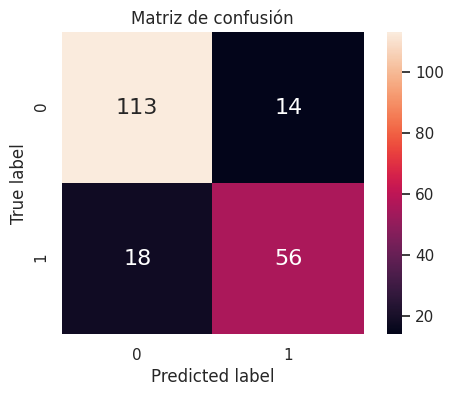

In [27]:
plot_confusion_matrix(y_test_2, arbol_2.predict(X_test_2))

# Segundo Holdout

In [28]:
df_h_2 = preprocesado_2(holdout, columnas_2)
df_h_2.head()

,genero_mujer,genero_nan,tipo_de_sala_normal,tipo_de_sala_nan,tipo_de_sala_4d,nombre_sede_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,amigos,precio_ticket,precio_ticket,id_usuario
0,1,0,0,0,1,0,1,0,0,1,1,650
1,1,0,0,0,1,0,1,0,4,4,4,234
2,0,0,1,0,0,0,0,0,0,3,3,31
3,0,0,0,0,0,0,1,0,0,3,3,552
4,0,0,0,0,1,0,1,0,0,1,1,411


In [29]:
df_resultado_2 = evaluate_holdout(df_h_2, arbol_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 12) 



,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [30]:
df_resultado.to_csv('prediccion/arbol_2do_prepoc_resultado_final.csv')